# Predicting Diatom concentration with functional clustering and a Histogram-based Gradient Boosting Regression Tree

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import scale
from skfda.representation.grid import FDataGrid
from skfda.ml.clustering import KMeans

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import r_regression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

import random

import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [2]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, clusters, name):
    
    inputs = np.stack([
        np.ravel(dataset2['Summation_of_solar_radiation']),
        np.ravel(dataset2['Mean_wind_speed']),
        np.ravel(dataset2['Mean_air_temperature']),
        np.repeat(dataset.time_counter.dt.dayofyear, len(dataset.x)*len(dataset.y))
        ])
    
    x = np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y))
    y = np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter))

    targets = np.ravel(dataset[name])
    
    indx = np.where(np.isfinite(targets) & (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,indx[0]]
    targets = targets[indx[0]]

    clusters = np.tile(np.ravel(clusters), len(dataset.time_counter))
    clusters = clusters[indx[0]]

    inputs = inputs.transpose()

    return(inputs, targets, indx, clusters)


## Functional Clustering (target)

In [3]:
def func_clust_target(dataset, name):

    id = 0 # To know which type of clustering was used

    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))

    input = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)
    input  = np.delete(input, indx,axis=0)
    input  = np.split(input, len(np.unique(dataset.time_counter.dt.year)),axis=0)

    input  = np.nanmean(input,axis=0)

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(input).any(axis=0)) & (x>10) & ((x>100) | (y<880))) 
    input = input[:, indx[0]]

    input = input.transpose()

    # Converting it to an appropriate format for functional clustering
    input2 = FDataGrid(input)

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(input2)
    clusters = kmeans.predict(input2)

    unique, _ = np.unique(clusters, return_counts=True)

    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

    # Preparation of the dataarray 
    clusters2 = xr.DataArray(clusters,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed functional analysis algorithm",
        long_name ="Cluster",
        units="count"))
    
    # Plotting
    fig, ax = plt.subplots(figsize =(5,9))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')
    clus = clusters2.plot(ax=ax, cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')
    ax.set_title('Functional Clustering for '+ name + ' (2007-2020)')

    sa_vi.set_aspect(ax)

    plt.show()

    return(clusters,id)


## Functional Clustering (Drivers)

In [4]:
def func_clust_drivers(dataset, dataset2,name):

    id = 1 # To know which type of clustering was used

    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))

    inputs = np.stack([
        dataset2['Summation_of_solar_radiation'].to_numpy().reshape(*dataset2['Summation_of_solar_radiation'].to_numpy().shape[:1],-1),
        dataset2['Mean_wind_speed'].to_numpy().reshape(*dataset2['Mean_wind_speed'].to_numpy().shape[:1],-1),
        dataset2['Mean_air_temperature'].to_numpy().reshape(*dataset2['Mean_air_temperature'].to_numpy().shape[:1],-1),
        ])
    
    target= dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    # Deleting 29 of February
    inputs = np.delete(inputs,indx,axis=1)
    target = np.delete(target,indx,axis=0)

    # Splitting in years
    inputs = np.split(inputs,len(np.unique(dataset.time_counter.dt.year)),axis=1)
    target = np.split(target,len(np.unique(dataset.time_counter.dt.year)),axis=0)

    inputs = np.nanmean(inputs,axis=1)
    target = np.nanmean(target,axis=0)

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(target).any(axis=0)) & (x>10) & ((x>100) | (y<880))) 
    inputs =inputs[:,:,indx[0]]

    # Transforming each variable individually
    for j in range (0, len(inputs)):

        temp = scale(np.ravel(inputs[j]))
        inputs[j] = temp.reshape(inputs[j].shape)

    # Converting it to an appropriate format for functional clustering
    inputs = np.transpose(inputs,axes=(2,1,0)) # this is the right shape for converting it to a functional variable
    input2 = FDataGrid(inputs, np.arange(0,len(inputs[0])))

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(input2)
    clusters = kmeans.predict(input2)

    unique, _ = np.unique(clusters, return_counts=True)

    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

    # Preparation of the dataarray 
    clusters2 = xr.DataArray(clusters,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed functional analysis algorithm",
        long_name ="Cluster",
        units="count"))

    # Plotting
    fig, ax = plt.subplots(figsize =(5,9))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')
    clus = clusters2.plot(ax=ax, cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')
    ax.set_title('Functional Clustering for inputs (2007-2020)')

    sa_vi.set_aspect(ax)

    plt.show()

    return(clusters, id)


## Datasets Preparation 2

In [5]:
# Creation of the data arrays
def datasets_preparation2(variable, name, units, dataset):

    # Obtaining the daily indexes
    temp = np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(temp).any(axis=0)) & (x>10) & ((x>100) | (y<880)))

    variable_all = np.full((len(dataset.time_counter), len(dataset.y) * len(dataset.x)),np.nan)
    variable_all[:,indx[0]] = variable
    variable_all = np.reshape(variable_all,(len(dataset.time_counter),len(dataset.y),len(dataset.x)))

    # Preparation of the dataarray 
    array = xr.DataArray(variable_all,
        coords = {'time_counter': dataset.time_counter,'y': dataset.y, 'x': dataset.x},
        dims = ['time_counter','y','x'],
        attrs=dict(description= name,
        units=units))
        
    return (array)


## File Creation

In [6]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [7]:
def regressor (inputs, targets, clusters):

    model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
        transformers=[('drivers', StandardScaler(), [0,1,2])],remainder='passthrough'),
        HistGradientBoostingRegressor(learning_rate=0.5, categorical_features=[3])),
        transformer=StandardScaler())
    
    regr_all = []
    r = []
    rms = []
    slope = []
    
    for i in range (0,len(np.unique(clusters))):
        indx2 = np.where(clusters==i) # indexes of the i cluster
        inputs2 = inputs[indx2[0]] # inputs of the i cluster
        targets2 = targets[indx2[0]]

        regr = BaggingRegressor(model, n_estimators=12, n_jobs=4).fit(inputs2,targets2)
        
        r.append(np.corrcoef(regr.predict(inputs2),targets2)[0][1])
        rms.append(rmse(regr.predict(inputs2),targets2))
        m,_ = np.polyfit(regr.predict(inputs2), targets2, deg=1)
        slope.append(m)

        regr_all.append(regr)

    print ('The mean correlation coefficient during training is: ' + str(np.round(np.mean(r),3)))
    print ('The mean rmse during training is: ' + str(np.mean(rms)))
    print('The mean slope of the best fitting line during training is: '+str(np.round(np.mean(m),3)))

    return(regr_all)


## Scatter Plot

In [8]:
def scatter_plot(targets, predictions, name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,predictions, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('predictions')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,predictions, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm='log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('predictions')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(name)

    plt.show()

    return(m)


## Plotting (Criteria)

In [9]:
def plotting_criteria(dates, variable, year_variable, title):
    
    indx = pd.DatetimeIndex(dates)
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=indx.month)
    plt.xticks(rotation=70)
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    ax.plot(dates[(indx.month == 3) & (indx.day == 15)], year_variable,color='red',marker='*')
    fig.suptitle(title + ' (15 Feb - 30 Apr)')
    
    fig.show()


## Plotting (Mean Values)

In [10]:
def plotting_mean_values(dates, mean_targets, mean_predictions, units, category):

    fig, _ = plt.subplots(figsize=(9,5))
    
    mean_targets = np.ma.array(mean_targets)
    mean_targets[75]=np.ma.masked
    mean_targets[150]=np.ma.masked
    mean_targets[225]=np.ma.masked

    mean_predictions = np.ma.array(mean_predictions)
    mean_predictions[75]=np.ma.masked
    mean_predictions[150]=np.ma.masked
    mean_predictions[225]=np.ma.masked

    plt.plot(mean_targets, label = 'targets')
    plt.plot(mean_predictions, label = 'predictions')
    plt.xlabel('Days')
    # plt.xticks(rotation=70)
    plt.suptitle('Mean '+category + ' ' +units + ' (15 Feb - 30 Apr)')
    plt.legend()
    fig.show()
    

## Plotting (Maps)

In [11]:
def plotting_maps(targets, predictions, name, units):

    fig, ax = plt.subplots(2,2, figsize = (10,15), layout='tight')

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    targets.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    predictions.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    (targets-predictions).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': name + ' ' + units})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Targets')
    ax[0,1].title.set_text('Predictions')
    ax[1,0].title.set_text('Targets-Predictions')
    ax[1,1].axis('off')

    fig.suptitle(name + ' '+ str(targets.time_counter.dt.date.values))

    plt.show()
    

## Evaluation

In [12]:
def evaluation (regr_all, clusters0, ds, ds2, name, units):

    years = np.unique(ds.time_counter.dt.year)

    # For every year
    r_years = np.array([])
    rms_years = np.array([])
    slope_years = np.array([])

    # The data arrays 
    targets_all = []
    predictions_all = []

    for year in (years):

        dataset = ds.sel(time_counter=str(year))
        dataset2 = ds2.sel(time_counter=str(year))

        inputs, targets, indx, clusters  = datasets_preparation(dataset, dataset2, clusters0, name)

        # Predictions for each regressor

        predictions = np.full(len(targets),np.nan) # size of a year without nans
        for i in range (0,len(np.unique(clusters))):
            indx2 = np.where(clusters==i) # indexes of the j cluster
            inputs2 = inputs[indx2[0]] # inputs of the j cluster
            predictions[indx2[0]] = regr_all[i].predict(inputs2) # putting them in the right place

        # Calculating the annual time-series
        m_year = scatter_plot(targets, predictions, name + ' for '+ str(year)) 
        r_year = np.round(np.corrcoef(targets, predictions)[0][1],3)
        rms_year = rmse(targets, predictions)
        
        r_years = np.append(r_years,r_year)
        rms_years = np.append(rms_years,rms_year)
        slope_years = np.append(slope_years,m_year)

        # Daily arrays
        targets = np.reshape(targets,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        predictions = np.reshape(predictions,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        targets_all.append (datasets_preparation2(targets, name + ' _targets', units, dataset))
        predictions_all.append(datasets_preparation2(predictions, name + ' _predictions', units, dataset))   

    # Daily arrays
    targets_all = xr.concat(targets_all, dim='time_counter')
    predictions_all = xr.concat(predictions_all, dim='time_counter')
    
    return(r_years, rms_years, slope_years, targets_all, predictions_all)


## Training

/tmp/ipykernel_3217/208693475.py:23: RuntimeWarning: Mean of empty slice
  inputs = np.nanmean(inputs,axis=1)
/tmp/ipykernel_3217/208693475.py:24: RuntimeWarning: Mean of empty slice
  target = np.nanmean(target,axis=0)


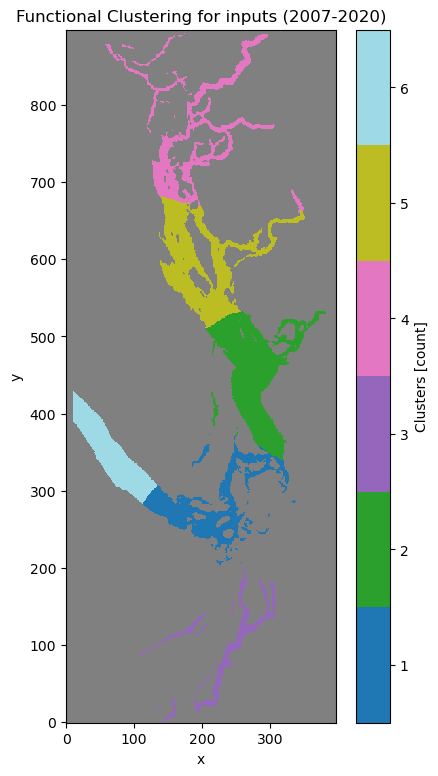

In [13]:
name = 'Diatom_Production_Rate'
units = '[mmol N m-2 s-1]'
category = 'production rates'

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# ds2 = ds2.isel(y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
#     x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

# Selecting the clustering input (drivers or target)
# clusters0, id = func_clust_target(dataset, name)
clusters0, id = func_clust_drivers(dataset,dataset2, name)

inputs, targets, _, clusters = datasets_preparation(dataset, dataset2, clusters0, name)

regr_all = regressor(inputs, targets, clusters)


## Other Years

In [ ]:
ds = ds.sel(time_counter = slice('2021', '2024'))
ds2 = ds2.sel(time_counter = slice('2021', '2024'))

dates = pd.DatetimeIndex(ds['time_counter'].values)

r_years, rms_years, slope_years, targets_all, predictions_all = evaluation(regr_all, clusters0, ds,ds2, name, units)

r_days = xr.corr(targets_all,predictions_all, dim=['x','y'])
rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True)
slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True)

mean_targets = targets_all.mean(dim=['x','y'], skipna=True)
mean_predictions = predictions_all.mean(dim=['x','y'], skipna=True)


## Plotting (Results)

In [ ]:
plotting_criteria(dates, r_days, r_years, 'Correlation Coefficients')
plotting_criteria(dates, rms_days, rms_years, 'Root Mean Square Errors')
plotting_criteria(dates, slope_days, slope_years, 'Slopes of the best fitting line')

plotting_mean_values(dates, mean_targets, mean_predictions, units, category)

# Daily maps
maps = random.sample(sorted(np.arange(0,len(targets_all.time_counter))),10)
for i in maps:

    idx = np.isfinite(np.ravel(targets_all[i]))
    scatter_plot(np.ravel(targets_all[i])[idx], np.ravel(predictions_all[i])[idx], name + ' '+ str(targets_all[i].time_counter.dt.date.values))

    plotting_maps(targets_all[i], predictions_all[i], name, units)
    

## Saving

In [ ]:
# if id == 0:
#     path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_cl_target_ext/'
# else:
#     path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_cl_drivers_ext/'

# os.makedirs(path, exist_ok=True)
# with lzma.open(path + 'regr.xz', 'wb') as f:
#     dill.dump(regr_all, f)

# file_creation(path, targets_all, 'Targets')
# file_creation(path, predictions_all, 'Predictions')
# file_creation(path, (targets_all-predictions_all), 'Targets - Predictions')
